# Diabetes Dataset Classification

LOAD DATA

In [31]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)
y = diabetes_data["Diabetes_binary"]

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()

# Keep a portion of the dataset for training
size = 0.8
X_train, X_temp, Y_train,  Y_temp = train_test_split(X, Y, test_size=size, random_state=42, stratify=Y)

print("Training set size:", X_train.shape)
print("Y_train size:", Y_train.shape)

Training set size: (50736, 21)
Y_train size: (50736,)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print(X_train.shape)

(30441, 21)


In [33]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))


Accuracy: 0.8626330311391407


In [34]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [35]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create dataloaders ####
batch_size = 32
train_loader, val_loader   = datasets_and_loaders(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 16
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

c:\Users\alexd\Github\Intro-ML-Mini-Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 14.4288  Train acc 62.36% | Val loss 14.1229  Val acc 67.76%
[Epoch   5/50] LR 1.000e-03 | Train loss 14.0613  Train acc 71.45% | Val loss 14.0552  Val acc 71.24%
[Epoch  10/50] LR 1.000e-03 | Train loss 14.0475  Train acc 72.05% | Val loss 14.0559  Val acc 70.97%
[Epoch  15/50] LR 1.000e-03 | Train loss 14.0303  Train acc 72.23% | Val loss 14.0537  Val acc 71.87%
[Epoch  20/50] LR 1.000e-04 | Train loss 14.0128  Train acc 72.43% | Val loss 14.0537  Val acc 71.61%
[Epoch  25/50] LR 1.000e-05 | Train loss 14.0164  Train acc 72.50% | Val loss 14.0544  Val acc 71.71%
[Epoch  30/50] LR 1.000e-06 | Train loss 14.0064  Train acc 72.49% | Val loss 14.0544  Val acc 71.70%
[Epoch  35/50] LR 1.000e-06 | Train loss 14.0074  Train acc 72.50% | Val loss 14.0544  Val acc 71.70%
[Epoch  40/50] LR 1.000e-07 | Train loss 14.0033  Train acc 72.50% | Val loss 14.0544  Val acc 71.70%
[Epoch  45/50] LR 1.000e-08 | Train loss 14.0103  Train acc 72.50% | Val loss 14.0

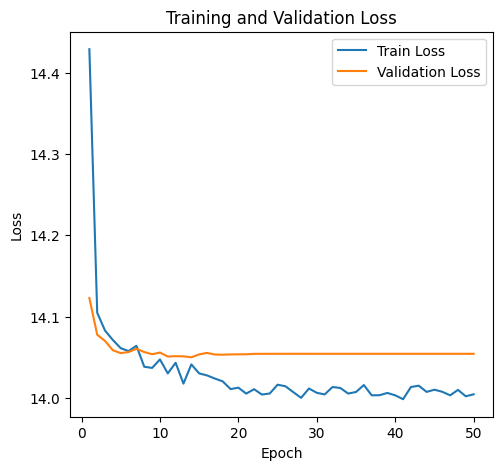

In [36]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()



In [37]:
##### Balance the dataset  #####

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, Y_train)

unique_train, counts_train = np.unique(Y_train, return_counts=True)
unique_bal, counts_bal = np.unique(y_train_bal, return_counts=True)

print("Avant SMOTE :", X_train.shape, " / ", dict(zip(unique_train, counts_train)))
print("Après SMOTE :", X_train_bal.shape, " / ", dict(zip(unique_bal, counts_bal)))

Avant SMOTE : (30441, 21)  /  {np.float64(0.0): np.int64(26200), np.float64(1.0): np.int64(4241)}
Après SMOTE : (52400, 21)  /  {np.float64(0.0): np.int64(26200), np.float64(1.0): np.int64(26200)}


In [40]:
size = 0.8
X_train, X_temp, Y_train,  Y_temp = train_test_split(X, Y, test_size=size, random_state=42, stratify=Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

In [41]:
X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train_bal, y_train_bal, X_val, Y_val, X_test, Y_test)

from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create dataloaders ####
batch_size = 32
train_loader, val_loader   = datasets_and_loaders(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 16
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None



c:\Users\alexd\Github\Intro-ML-Mini-Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 53.1943  Train acc 75.21% | Val loss 14.1049  Val acc 67.24%
[Epoch   5/50] LR 1.000e-03 | Train loss 52.6449  Train acc 78.28% | Val loss 14.1353  Val acc 68.37%
[Epoch  10/50] LR 1.000e-04 | Train loss 52.3951  Train acc 80.55% | Val loss 14.1747  Val acc 72.10%
[Epoch  15/50] LR 1.000e-05 | Train loss 52.3749  Train acc 80.78% | Val loss 14.1783  Val acc 72.26%
[Epoch  20/50] LR 1.000e-05 | Train loss 52.3741  Train acc 80.79% | Val loss 14.1798  Val acc 72.33%
[Epoch  25/50] LR 1.000e-06 | Train loss 52.3738  Train acc 80.80% | Val loss 14.1799  Val acc 72.32%
[Epoch  30/50] LR 1.000e-07 | Train loss 52.3588  Train acc 80.80% | Val loss 14.1799  Val acc 72.33%
[Epoch  35/50] LR 1.000e-08 | Train loss 52.3762  Train acc 80.80% | Val loss 14.1799  Val acc 72.33%
[Epoch  40/50] LR 1.000e-08 | Train loss 52.3735  Train acc 80.80% | Val loss 14.1799  Val acc 72.33%
[Epoch  45/50] LR 1.000e-08 | Train loss 52.3819  Train acc 80.80% | Val loss 14.1

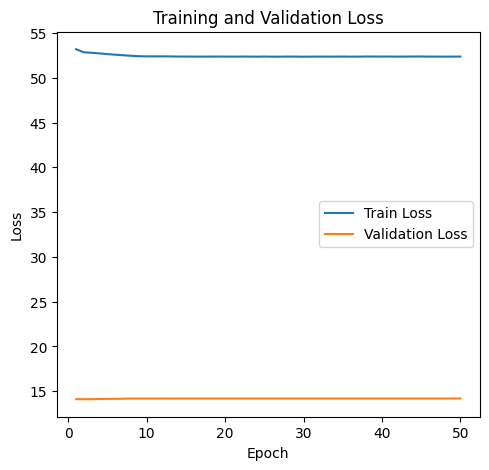

In [42]:
history_bal = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bal["epoch"], history_bal["train_loss"], label="Train Loss")
plt.plot(history_bal["epoch"], history_bal["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()